<a href="https://colab.research.google.com/github/mykon23/DL-2020Project/blob/effects_of_aug/Equus5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get the Equus Dataset

In [144]:
! wget -O Equus.tar.gz https://github.com/mykon23/DL-2020Project/blob/master/Equus.tar.gz?raw=true

--2020-04-16 05:40:02--  https://github.com/mykon23/DL-2020Project/blob/master/Equus.tar.gz?raw=true
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mykon23/DL-2020Project/raw/master/Equus.tar.gz [following]
--2020-04-16 05:40:03--  https://github.com/mykon23/DL-2020Project/raw/master/Equus.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mykon23/DL-2020Project/master/Equus.tar.gz [following]
--2020-04-16 05:40:03--  https://raw.githubusercontent.com/mykon23/DL-2020Project/master/Equus.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting resp

In [0]:
! rm -rf Equus
! tar -zxf Equus.tar.gz

In [0]:
! rm *.tar.gz
! rm -rf train/
! rm -rf validation/
! rm -rf test/

Create the Training Set, Validation Set, and Test Set

In [0]:
import os

##Creates the folder structure of the data staging locations
def set_dataset_loc(loc, sub_dirs):
  if not os.path.exists(loc):
    os.mkdir(loc)
    for s in sub_dirs:
      os.mkdir(os.path.join(loc, s))


dataset_dir = os.path.join('.', 'Equus')
lst_members = os.listdir(dataset_dir)

set_dataset_loc(os.path.join('.', 'train'), lst_members)
set_dataset_loc(os.path.join('.', 'validation'), lst_members)
set_dataset_loc(os.path.join('.', 'test'), lst_members)


In [148]:
##Display distribution of data

for d in os.listdir(dataset_dir):
  print(f'{d}: {len(os.listdir(os.path.join(dataset_dir, d)))}')

Horse: 314
Donkey: 391
Zebra: 339


In [149]:
!ls -lh

total 144M
-rw-r--r-- 1 root root 7.2M Apr 16 05:37 4ConvMaxPool3Dense3Batch.h5
-rw-r--r-- 1 root root 7.2M Apr 16 04:55 4ConvMaxPool3DenseBaseline.h5
-rw-r--r-- 1 root root 7.2M Apr 16 05:07 4ConvMaxPool3DenseDropout2.h5
-rw-r--r-- 1 root root 7.2M Apr 16 05:11 4ConvMaxPool3DenseDropout5.h5
-rw-r--r-- 1 root root 7.2M Apr 16 04:59 4ConvMaxPool3Dense.h5
-rw-r--r-- 1 root root  24M Apr 16 03:03 4ConvMaxPool3DensePrimeBasline.h5
-rw-r--r-- 1 root root  24M Apr 16 03:25 4ConvMaxPool3DensePrime.h5
-rw-r--r-- 1 root root  24M Apr 16 03:47 4ConvMaxPool3DensePrimeRot.h5
-rw-r--r-- 1 root root  24M Apr 16 03:37 4ConvMaxPool3DensePrimeXyZ.h5
-rw-r--r-- 1 root root 7.2M Apr 16 05:27 4ConvMaxPool3DenseRot.h5
-rw-r--r-- 1 root root 7.2M Apr 16 05:21 4ConvMaxPool3DenseXyZ.h5
drwxr-xr-x 5 root root 4.0K Mar 16 03:00 Equus
drwxr-xr-x 1 root root 4.0K Apr  3 16:24 sample_data
drwxr-xr-x 5 root root 4.0K Apr 16 05:40 test
drwxr-xr-x 5 root root 4.0K Apr 16 05:40 train
drwxr-xr-x 5 root root 4.0K Apr 16

In [0]:
import shutil

##Populate the staging locations for the data
def stage_data_loc(stage_loc, data_loc, dict_ind):

  ##Create a dictionary containing the images
  dict_images = { k : os.listdir(os.path.join(data_loc, k)) for k in lst_members }

  for k in dict_images.keys():
    for i in range(dict_ind[k][0], dict_ind[k][1]):
      src = os.path.join(os.path.join(data_loc, k), dict_images[k][i])
      dst = os.path.join(os.path.join(stage_loc, k), dict_images[k][i])
      shutil.copyfile(src, dst)

##Keep indices for the data splits
dict_train = {'Donkey': [0, 240], 'Horse': [0, 185], 'Zebra':[0, 185]}
dict_val = {'Donkey': [240, 315], 'Horse': [185, 250], 'Zebra':[185, 249]}
dict_test = {'Donkey': [315, 391], 'Horse': [250, 314],'Zebra': [249, 339]}

stage_data_loc(os.path.join('.', 'train'), dataset_dir, dict_train)
stage_data_loc(os.path.join('.', 'validation'), dataset_dir, dict_val)
stage_data_loc(os.path.join('.', 'test'), dataset_dir, dict_test)


In [151]:
##Count the number of files within each directory
! ls -lh train/*/* | wc -l
! ls -lh validation/*/* | wc -l
! ls -lh test/*/* | wc -l

610
204
230


Define Train and Test Operations

In [0]:
import keras
import matplotlib.pyplot as plt
import tensorflow as tf

def train_model(model, train, val, model_path):
  ##Set the callbacks
  callback_list = [
  tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    ),
  tf.keras.callbacks.ModelCheckpoint(
      filepath=model_path,
      monitor='val_loss',
      save_best_only=True,
    )
  ]

  ##Train the model
  history = model.fit(
      train['gen'],
      steps_per_epoch=train['steps'],
      epochs=25,
      callbacks = callback_list,
      validation_data=val['gen'],
      validation_steps=val['steps'])
  
  return history

def disp_plot(history, title):
  plt.figure()
  plt.plot(history.history['accuracy'], 'bo', label='Training Acc')
  plt.plot(history.history['val_accuracy'], 'b', label='Validation Acc')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.title(title)
  plt.legend()
  plt.show()

  plt.figure()
  plt.plot(history.history['loss'], 'bo', label='Training Loss')
  plt.plot(history.history['val_loss'], 'b', label='Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.title(title)
  plt.legend()
  plt.show()

def test_model(model, test):
  ##Observe the results of the model against the test data
  test_loss, test_acc = model.evaluate(
    test['gen'],
    steps=test['steps']
  )
  
  return {'accuracy': test_acc, 'loss': test_loss }


Establish Baseline Data Generators

In [153]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join('.', 'train')
val_dir = os.path.join('.', 'validation')
test_dir = os.path.join('.', 'test')

train_batches = 61
val_batches = 17
test_batches = 23

##Create Development Set Generators
##Note that 61 * 10 = 610 training samples
train_generator = ImageDataGenerator(rescale=1./255,
                                     ).flow_from_directory(train_dir, target_size=(256, 256), batch_size=10, class_mode='categorical')
##Note that 17 * 12 = 240 validation samples
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=(256, 256), batch_size=12, class_mode='categorical')

##Create Test Generator
##Note that 23 * 10 = 230 Test samples
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, target_size=(256,256), batch_size=10, class_mode='categorical')

Found 610 images belonging to 3 classes.
Found 204 images belonging to 3 classes.
Found 230 images belonging to 3 classes.


Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_168 (Conv2D)          (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_126 (MaxPoolin (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_169 (Conv2D)          (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_127 (MaxPoolin (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_170 (Conv2D)          (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_128 (MaxPoolin (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 28, 28, 32)      

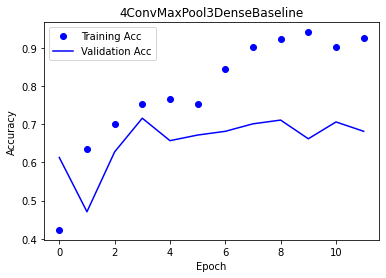

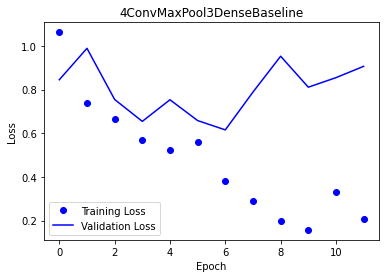

In [154]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 0.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseBaseline.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [155]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

23/23 [==============================] - 0s 20ms/step - loss: 0.5313 - accuracy: 0.7304
Test: {'accuracy': 0.730434775352478, 'loss': 0.5313270688056946}
17/17 [==============================] - 0s 24ms/step - loss: 0.7005 - accuracy: 0.6667
Val: {'accuracy': 0.6666666865348816, 'loss': 0.700518786907196}


Establish the Six Degrees of Freedom Data Generators

In [156]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join('.', 'train')
val_dir = os.path.join('.', 'validation')
test_dir = os.path.join('.', 'test')

train_batches = 61
val_batches = 17
test_batches = 23

##Create Development Set Generators
##Note that 61 * 10 = 610 training samples
train_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=60,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest',
                                     ).flow_from_directory(train_dir, target_size=(256, 256), batch_size=10, class_mode='categorical')
##Note that 17 * 12 = 240 validation samples
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=(256, 256), batch_size=12, class_mode='categorical')

##Create Test Generator
##Note that 23 * 10 = 230 Test samples
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, target_size=(256,256), batch_size=10, class_mode='categorical')

Found 610 images belonging to 3 classes.
Found 204 images belonging to 3 classes.
Found 230 images belonging to 3 classes.


Run Best Validation Loss Model Against Six Degree of Freedom Data

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_172 (Conv2D)          (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_129 (MaxPoolin (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_173 (Conv2D)          (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_130 (MaxPoolin (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_174 (Conv2D)          (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_131 (MaxPoolin (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_175 (Conv2D)          (None, 28, 28, 32)      

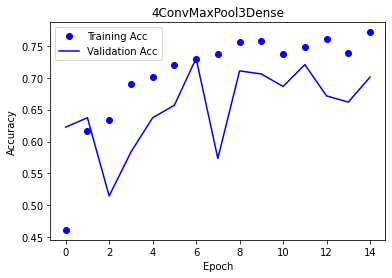

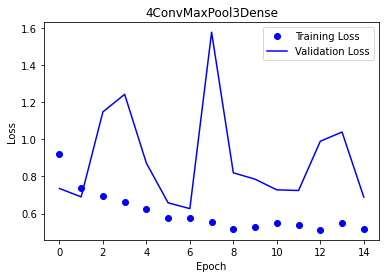

In [157]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 1.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3Dense.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [158]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

23/23 [==============================] - 0s 20ms/step - loss: 0.5842 - accuracy: 0.7609
Test: {'accuracy': 0.760869562625885, 'loss': 0.5842004418373108}
17/17 [==============================] - 0s 27ms/step - loss: 0.6626 - accuracy: 0.7010
Val: {'accuracy': 0.7009803652763367, 'loss': 0.6625620722770691}


Model with Data Augmentation and Dropout 0.2



Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_176 (Conv2D)          (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_132 (MaxPoolin (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_133 (MaxPoolin (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_178 (Conv2D)          (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_134 (MaxPoolin (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 28, 28, 32)      

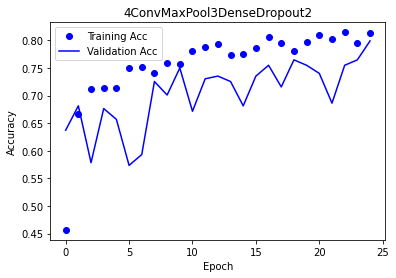

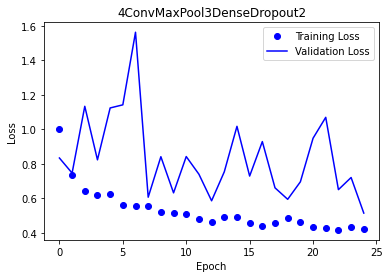

In [159]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( Flatten() )
model.add( Dropout(0.2) )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 1.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseDropout2.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [160]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

23/23 [==============================] - 0s 20ms/step - loss: 0.5023 - accuracy: 0.8130
Test: {'accuracy': 0.813043475151062, 'loss': 0.5023206472396851}
17/17 [==============================] - 0s 26ms/step - loss: 0.5436 - accuracy: 0.7647
Val: {'accuracy': 0.7647058963775635, 'loss': 0.5435891151428223}


Model with Data Augmentation and Dropout 0.5

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_180 (Conv2D)          (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_135 (MaxPoolin (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_136 (MaxPoolin (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_182 (Conv2D)          (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_137 (MaxPoolin (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_183 (Conv2D)          (None, 28, 28, 32)      

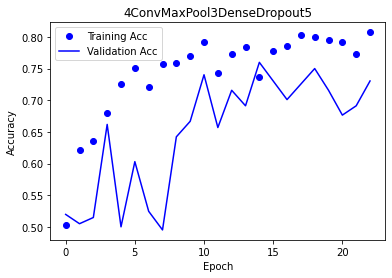

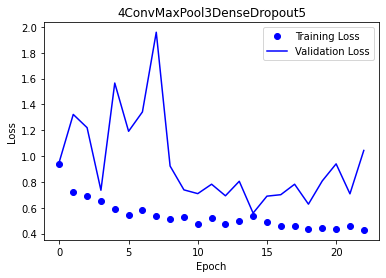

In [161]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( Flatten() )
model.add( Dropout(0.5) )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 1.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseDropout5.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [162]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

23/23 [==============================] - 0s 19ms/step - loss: 0.5220 - accuracy: 0.7783
Test: {'accuracy': 0.7782608866691589, 'loss': 0.5219878554344177}
17/17 [==============================] - 0s 28ms/step - loss: 0.6155 - accuracy: 0.7353
Val: {'accuracy': 0.7352941036224365, 'loss': 0.6155266761779785}


Establish Translations-Only Data Generators

In [163]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join('.', 'train')
val_dir = os.path.join('.', 'validation')
test_dir = os.path.join('.', 'test')

train_batches = 61
val_batches = 17
test_batches = 23

##Create Development Set Generators
##Note that 61 * 10 = 610 training samples
train_generator = ImageDataGenerator(rescale=1./255,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     fill_mode='nearest',
                                     ).flow_from_directory(train_dir, target_size=(256, 256), batch_size=10, class_mode='categorical')
##Note that 17 * 12 = 240 validation samples
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=(256, 256), batch_size=12, class_mode='categorical')

##Create Test Generator
##Note that 23 * 10 = 230 Test samples
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, target_size=(256,256), batch_size=10, class_mode='categorical')

Found 610 images belonging to 3 classes.
Found 204 images belonging to 3 classes.
Found 230 images belonging to 3 classes.


Run Model Against Translations-Only Data Generators

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_184 (Conv2D)          (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_138 (MaxPoolin (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_185 (Conv2D)          (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_139 (MaxPoolin (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_186 (Conv2D)          (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_140 (MaxPoolin (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_187 (Conv2D)          (None, 28, 28, 32)      

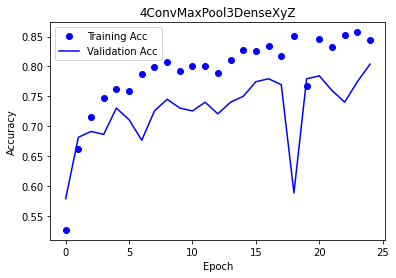

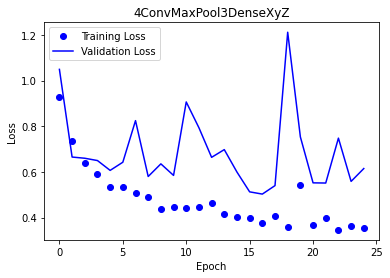

In [164]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 1.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseXyZ.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [165]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

23/23 [==============================] - 0s 20ms/step - loss: 0.4287 - accuracy: 0.8130
Test: {'accuracy': 0.813043475151062, 'loss': 0.428727924823761}
17/17 [==============================] - 0s 25ms/step - loss: 0.4898 - accuracy: 0.8039
Val: {'accuracy': 0.8039215803146362, 'loss': 0.4897559583187103}


Establish Rotations-Only Data Generators

In [166]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join('.', 'train')
val_dir = os.path.join('.', 'validation')
test_dir = os.path.join('.', 'test')

train_batches = 61
val_batches = 17
test_batches = 23

##Create Development Set Generators
##Note that 61 * 10 = 610 training samples
train_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=60,
                                     fill_mode='nearest',
                                     ).flow_from_directory(train_dir, target_size=(256, 256), batch_size=10, class_mode='categorical')
##Note that 17 * 12 = 240 validation samples
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=(256, 256), batch_size=12, class_mode='categorical')

##Create Test Generator
##Note that 23 * 10 = 230 Test samples
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, target_size=(256,256), batch_size=10, class_mode='categorical')

Found 610 images belonging to 3 classes.
Found 204 images belonging to 3 classes.
Found 230 images belonging to 3 classes.


Run Model on Rotations-Only Data Generators

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_188 (Conv2D)          (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_141 (MaxPoolin (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 125, 125, 12)      1308      
_________________________________________________________________
max_pooling2d_142 (MaxPoolin (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_190 (Conv2D)          (None, 60, 60, 32)        3488      
_________________________________________________________________
max_pooling2d_143 (MaxPoolin (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_191 (Conv2D)          (None, 28, 28, 32)      

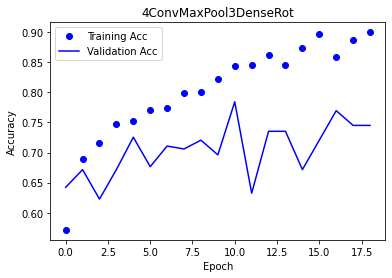

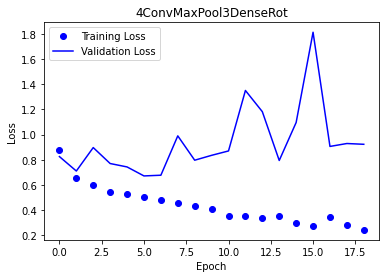

In [167]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu', input_shape = (256, 256, 3) ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 12, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D((2,2)) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPooling2D(2,2) )
model.add( Conv2D( 32, (3, 3 ), activation='relu') )
model.add( Flatten() )
model.add( Dense( 24, activation = 'relu' ) )
model.add( Dense( 12, activation = 'relu' ) )
model.add( Dense( 3, activation = 'softmax' ) )
model.summary()

##Compile the model
model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )

##Set the params from training
train = {'gen': train_generator, 'steps': int( (1 + 1.0) * train_batches) }
val = {'gen': val_generator, 'steps': val_batches }
test = {'gen': test_generator, 'steps': test_batches }

model_path = '4ConvMaxPool3DenseRot.h5'

##Train the model
history = train_model(model, train, val, model_path)
disp_plot(history, model_path.split('.')[0])

In [168]:
##Load the weights of the best model acquired in training
model.load_weights(model_path)

results = test_model(model, test)
print(f'Test: {results}')

results = test_model(model, val)
print(f'Val: {results}')

23/23 [==============================] - 0s 20ms/step - loss: 0.7253 - accuracy: 0.7217
Test: {'accuracy': 0.7217391133308411, 'loss': 0.7252683043479919}
17/17 [==============================] - 0s 26ms/step - loss: 0.8114 - accuracy: 0.6618
Val: {'accuracy': 0.6617646813392639, 'loss': 0.8113826513290405}
